In [2]:
import os
from typing import Dict, Any, List, Tuple
from huggingface_hub import login
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import userdata

from tqdm import tqdm
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    AutoModelForCausalLM,
    AutoTokenizer,
)
HF_TOKEN = userdata.get("HF_TOKEN")
login(token=HF_TOKEN)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_COSINE = True
DEFAULT_THRESHOLD = 0.8

OUTPUT_DIR = "./outputs_networks"
os.makedirs(OUTPUT_DIR, exist_ok=True)

CORPUS: List[str] = [
    "The cat sat on the mat.",
    "Climate change is a global challenge that requires urgent action.",
    "Quantum computing may revolutionize cryptography and optimization.",
    "The universe is vast and full of mysteries we have yet to uncover.",
    "Artificial intelligence can help us analyze large datasets efficiently.",
    "DNA encodes the genetic information necessary for life.",
    "The stock market fluctuates based on investor expectations and news.",
    "The brain is composed of billions of neurons forming complex networks.",
    "Mathematics provides a language to describe patterns in nature.",
    "Music can evoke powerful emotions and memories in people.",
    "For centuries, people believed that the Earth was flat, "
    "but modern science has shown with overwhelming evidence that our planet "
    "is an oblate spheroid, orbiting the Sun together with other planets."
]


MODEL_SPECS = [
    {
        "id": "gpt2",
        "hf_name": "gpt2",
        "model_class": GPT2LMHeadModel,
        "tokenizer_class": GPT2Tokenizer,
        "max_length": 40,
        "trust_remote_code": False,
    },
    {
        "id": "qwen1_5",
        "hf_name": "Qwen/Qwen1.5-0.5B",
        "model_class": AutoModelForCausalLM,
        "tokenizer_class": AutoTokenizer,
        "max_length": 40,
        "trust_remote_code": True,
    },
    {
        "id": "qwen2_5",
        "hf_name": "Qwen/Qwen2.5-0.5B",
        "model_class": AutoModelForCausalLM,
        "tokenizer_class": AutoTokenizer,
        "max_length": 40,
        "trust_remote_code": True,
    },
    {
        "id": "qwen3",
        "hf_name": "Qwen/Qwen3-0.6B-base",
        "model_class": AutoModelForCausalLM,
        "tokenizer_class": AutoTokenizer,
        "max_length": 40,
        "trust_remote_code": True,
    },
]


def load_model_and_tokenizer_from_spec(
    spec: Dict[str, Any],
    device: str = DEVICE,
):
    print(f"Loading model: {spec['hf_name']} on {device}...")
    tokenizer = spec["tokenizer_class"].from_pretrained(
        spec["hf_name"],
        trust_remote_code=spec.get("trust_remote_code", False),
    )
    model = spec["model_class"].from_pretrained(
        spec["hf_name"],
        output_hidden_states=True,
        trust_remote_code=spec.get("trust_remote_code", False),
    ).to(device)
    model.eval()
    return model, tokenizer


In [3]:
# Core utilities (hidden states, similarity, graph, visualization)

def extract_hidden_states(
    model,
    tokenizer,
    text: str,
    max_length: int = 40,
    device: str = DEVICE,
) -> Tuple[List[np.ndarray], List[str]]:
    """
    Run the model on a single text and return:
    - hidden_arrays: list of [seq_len, hidden_dim] per layer
    - tokens: list of token strings
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states  # tuple: (layer0, layer1, ..., layerL)

    hidden_arrays = [h[0].cpu().numpy() for h in hidden_states]  # [seq_len, dim]
    token_ids = inputs["input_ids"][0]
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    return hidden_arrays, tokens


def compute_similarity_matrix(
    hidden_state: np.ndarray,
    use_cosine: bool = True,
) -> np.ndarray:
    """
    hidden_state: [seq_len, hidden_dim]
    return: [seq_len, seq_len] similarity matrix
    """
    if use_cosine:
        norms = np.linalg.norm(hidden_state, axis=1, keepdims=True) + 1e-9
        hs_norm = hidden_state / norms
        sim = hs_norm @ hs_norm.T
    else:
        sim = hidden_state @ hidden_state.T
    return sim


def build_connectivity_graph(
    similarity_matrix: np.ndarray,
    threshold: float,
    tokens: List[str],
) -> nx.Graph:
    """
    Build an undirected graph where nodes are tokens,
    and edges connect pairs with similarity > threshold.
    """
    n = len(tokens)
    G = nx.Graph()
    for i in range(n):
        G.add_node(i, token=tokens[i])

    for i in range(n):
        for j in range(i + 1, n):
            sim_ij = similarity_matrix[i, j]
            if sim_ij > threshold:
                G.add_edge(i, j, weight=float(sim_ij))

    return G


def analyze_graph_structure(G: nx.Graph) -> Dict[str, Any]:
    """
    Return percolation-style observables:
    - component_sizes
    - largest_component_size
    - phi: largest_component_size / num_nodes
    - num_clusters
    - chi: mean cluster size excluding GCC
    """
    num_nodes = G.number_of_nodes()
    if num_nodes == 0:
        return {
            "component_sizes": [],
            "largest_component_size": 0,
            "phi": 0.0,
            "num_clusters": 0,
            "chi": 0.0,
        }

    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]
    largest_component_size = max(component_sizes)

    phi = largest_component_size / num_nodes
    num_clusters = len(component_sizes)

    finite_sizes = [s for s in component_sizes if s < largest_component_size]
    if len(finite_sizes) > 0:
        chi = float(np.mean(finite_sizes))
    else:
        chi = 0.0

    return {
        "component_sizes": component_sizes,
        "largest_component_size": largest_component_size,
        "phi": float(phi),
        "num_clusters": num_clusters,
        "chi": chi,
    }


def visualize_network(
    G: nx.Graph,
    tokens: List[str],
    layer_num: int,
    title: str = "",
    ax=None,
    layout: str = "spring",
):
    """
    Draw a token similarity graph with connected components colored differently.
    """
    if ax is None:
        ax = plt.gca()

    if len(G) == 0:
        ax.set_axis_off()
        ax.set_title(f"Layer {layer_num}: Empty graph")
        return

    if layout == "spring":
        pos = nx.spring_layout(G, seed=42, k=0.5)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42)

    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]
    largest_size = max(component_sizes)

    color_map = []
    for node in G.nodes():
        comp_idx = None
        for i, comp in enumerate(components):
            if node in comp:
                comp_idx = i
                break
        size = component_sizes[comp_idx]
        if size == largest_size and largest_size > 1:
            color_map.append("tab:red")
        else:
            color_map.append("tab:blue")

    nx.draw_networkx_nodes(G, pos, node_size=400, node_color=color_map, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax)
    labels = {i: tokens[i] for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, ax=ax)

    stats = analyze_graph_structure(G)
    phi = stats["phi"]
    num_clusters = stats["num_clusters"]
    largest_component_size = stats["largest_component_size"]
    n_nodes = G.number_of_nodes()

    if not title:
        title = (
            f"Layer {layer_num} | GCC: {largest_component_size}/{n_nodes} "
            f"(phi={phi:.2f}), clusters={num_clusters}"
        )
    ax.set_title(title, fontsize=9)
    ax.set_axis_off()


In [4]:
# Percolation wrappers (per text, over corpus, critical layer)

def percolation_stats_for_text(
    model,
    tokenizer,
    text: str,
    threshold: float = DEFAULT_THRESHOLD,
    use_cosine: bool = USE_COSINE,
    max_length: int = 40,
) -> Dict[str, Any]:
    """
    For a given text and model:
    - extract hidden states,
    - build graphs per layer,
    - compute percolation stats per layer.
    """
    hidden_arrays, tokens = extract_hidden_states(
        model, tokenizer, text, max_length=max_length, device=DEVICE
    )

    layer_stats = []
    for layer_idx, hidden_state in enumerate(hidden_arrays):
        sim = compute_similarity_matrix(hidden_state, use_cosine=use_cosine)
        G = build_connectivity_graph(sim, threshold=threshold, tokens=tokens)
        stats = analyze_graph_structure(G)
        stats["layer"] = layer_idx
        layer_stats.append(stats)

    return {
        "text": text,
        "tokens": tokens,
        "layer_stats": layer_stats,
    }


def aggregate_over_corpus(
    model,
    tokenizer,
    corpus: List[str],
    threshold: float = DEFAULT_THRESHOLD,
    max_length: int = 40,
) -> Tuple[Dict[int, Dict[str, float]], List[Dict[str, Any]]]:
    """
    Run percolation stats for each text, then aggregate per layer.
    """
    all_results: List[Dict[str, Any]] = []
    for text in tqdm(corpus, desc="Texts"):
        res = percolation_stats_for_text(
            model,
            tokenizer,
            text,
            threshold=threshold,
            max_length=max_length,
        )
        all_results.append(res)

    num_layers = len(all_results[0]["layer_stats"])
    aggregate: Dict[int, Dict[str, float]] = {}

    for layer_idx in range(num_layers):
        phi_vals = []
        num_clusters_vals = []
        chi_vals = []

        for res in all_results:
            s = res["layer_stats"][layer_idx]
            phi_vals.append(s["phi"])
            num_clusters_vals.append(s["num_clusters"])
            chi_vals.append(s["chi"])

        aggregate[layer_idx] = {
            "phi_mean": float(np.mean(phi_vals)),
            "phi_std": float(np.std(phi_vals)),
            "num_clusters_mean": float(np.mean(num_clusters_vals)),
            "num_clusters_std": float(np.std(num_clusters_vals)),
            "chi_mean": float(np.mean(chi_vals)),
            "chi_std": float(np.std(chi_vals)),
        }

    return aggregate, all_results


def find_critical_layer(
    aggregate_stats: Dict[int, Dict[str, float]],
    method: str = "max_derivative",
    phi_threshold: float = 0.5,
) -> int | None:
    """
    Approximate critical layer via:
    - 'max_derivative': argmax of Δphi(l)
    - 'phi_threshold': first layer with phi >= threshold
    """
    layers = sorted(aggregate_stats.keys())
    phi = np.array([aggregate_stats[l]["phi_mean"] for l in layers])

    if method == "max_derivative":
        if len(phi) < 2:
            return layers[0]
        dphi = np.diff(phi)
        start = 1
        idx = int(np.argmax(dphi[start:]) + start)
        return layers[idx]

    elif method == "phi_threshold":
        for l, p in zip(layers, phi):
            if p >= phi_threshold:
                return l
        return None

    else:
        raise ValueError(f"Unknown method: {method}")


In [5]:
# Single-text demo visualization

def demo_single_text_networks(
    model,
    tokenizer,
    text: str,
    threshold: float = DEFAULT_THRESHOLD,
    max_length: int = 40,
):
    """
    Show how one text's token network evolves across a few key layers.
    """
    hidden_arrays, tokens = extract_hidden_states(
        model, tokenizer, text, max_length=max_length, device=DEVICE
    )
    num_layers = len(hidden_arrays)
    key_layers = [0, 3, 6, 9, 10, 11, num_layers - 1]
    key_layers = sorted(set(l for l in key_layers if l < num_layers))

    n = len(key_layers)
    ncols = 4
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows, ncols, figsize=(4 * ncols, 3.3 * nrows),
        squeeze=False
    )

    for idx, layer in enumerate(key_layers):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r][c]

        hidden = hidden_arrays[layer]
        sim = compute_similarity_matrix(hidden, use_cosine=USE_COSINE)
        G = build_connectivity_graph(sim, threshold=threshold, tokens=tokens)
        visualize_network(
            G,
            tokens,
            layer_num=layer,
            title=f"Layer {layer}",
            ax=ax,
        )

    for idx in range(n, nrows * ncols):
        r = idx // ncols
        c = idx % ncols
        axes[r][c].set_axis_off()

    fig.suptitle("Token similarity networks across key layers", fontsize=12)
    plt.tight_layout()
    plt.show()


Loading model: gpt2 on cpu...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Example text:
 For centuries, people believed that the Earth was flat, but modern science has shown with overwhelming evidence that our planet is an oblate spheroid, orbiting the Sun together with other planets.


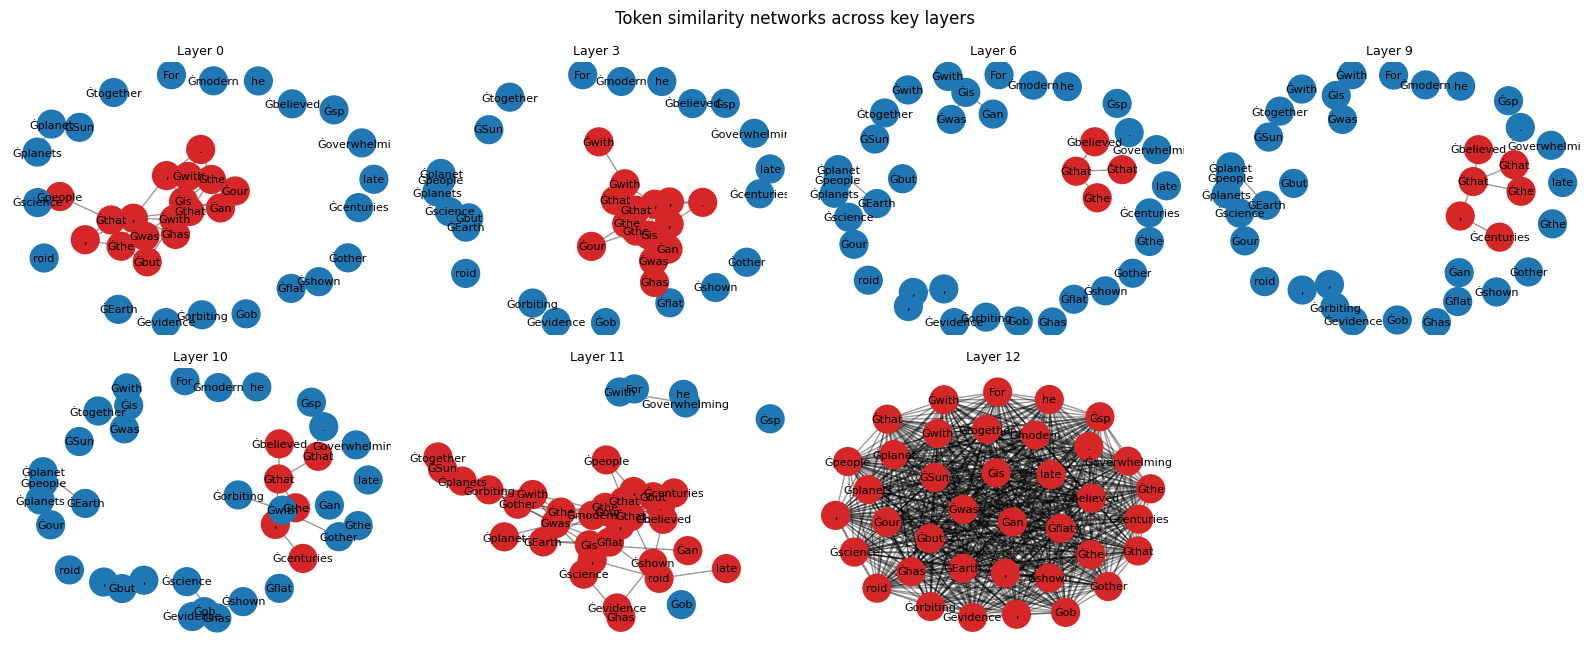

In [6]:
# GPT-2 single-text demo

base_spec = MODEL_SPECS[0]  # gpt2
base_model, base_tokenizer = load_model_and_tokenizer_from_spec(base_spec)

example_text = CORPUS[-1]
print("Example text:\n", example_text)

demo_single_text_networks(
    base_model,
    base_tokenizer,
    example_text,
    threshold=DEFAULT_THRESHOLD,
    max_length=base_spec["max_length"],
)


In [7]:
# Run all models → compute aggregated stats + critical layers

model_results: Dict[str, Dict[int, Dict[str, float]]] = {}
critical_layers: Dict[str, int | None] = {}

for spec in MODEL_SPECS:
    print(f"\n=== Running model: {spec['id']} ===")
    model, tokenizer = load_model_and_tokenizer_from_spec(spec)

    aggregate, all_results = aggregate_over_corpus(
        model,
        tokenizer,
        CORPUS,
        threshold=DEFAULT_THRESHOLD,
        max_length=spec["max_length"],
    )

    model_results[spec['id']] = aggregate

    crit_layer = find_critical_layer(
        aggregate,
        method="max_derivative",
        phi_threshold=0.5
    )
    critical_layers[spec['id']] = crit_layer

    print(f"Critical layer for {spec['id']} (max Δphi): {crit_layer}")



=== Running model: gpt2 ===
Loading model: gpt2 on cpu...


Texts: 100%|██████████| 11/11 [00:00<00:00, 18.45it/s]


Critical layer for gpt2 (max Δphi): 10

=== Running model: qwen1_5 ===
Loading model: Qwen/Qwen1.5-0.5B on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Texts: 100%|██████████| 11/11 [00:01<00:00,  5.69it/s]

Critical layer for qwen1_5 (max Δphi): 22

=== Running model: qwen2_5 ===
Loading model: Qwen/Qwen2.5-0.5B on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Texts: 100%|██████████| 11/11 [00:02<00:00,  5.43it/s]

Critical layer for qwen2_5 (max Δphi): 21

=== Running model: qwen3 ===
Loading model: Qwen/Qwen3-0.6B-base on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Texts: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s]

Critical layer for qwen3 (max Δphi): 25


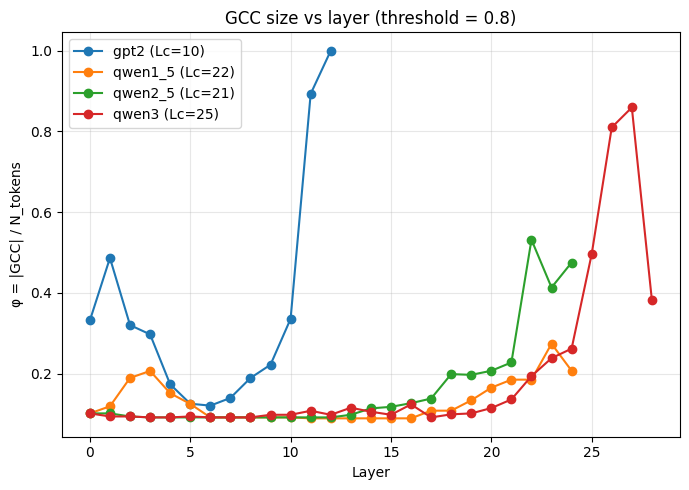

In [8]:
# Plot cross-model GCC (phi) curves

plt.figure(figsize=(7, 5))

for model_id, aggregate in model_results.items():
    layers = sorted(aggregate.keys())
    phi_mean = [aggregate[l]["phi_mean"] for l in layers]

    label = model_id
    if critical_layers[model_id] is not None:
        label += f" (Lc={critical_layers[model_id]})"

    plt.plot(layers, phi_mean, marker="o", label=label)

plt.xlabel("Layer")
plt.ylabel("φ = |GCC| / N_tokens")
plt.title(f"GCC size vs layer (threshold = {DEFAULT_THRESHOLD})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
inspect_id = "gpt2"

if inspect_id in model_results:
    print(f"\nPer-layer aggregated stats for model: {inspect_id}")
    agg = model_results[inspect_id]

    for l in sorted(agg.keys()):
        s = agg[l]
        print(
            f"Layer {l:2d} | "
            f"phi={s['phi_mean']:.3f}±{s['phi_std']:.3f}, "
            f"#clusters={s['num_clusters_mean']:.2f}±{s['num_clusters_std']:.2f}, "
            f"chi={s['chi_mean']:.2f}±{s['chi_std']:.2f}"
        )
else:
    print(f"Model '{inspect_id}' not found in model_results.")


Per-layer aggregated stats for model: gpt2
Layer  0 | phi=0.332±0.113, #clusters=9.55±3.92, chi=0.91±0.29
Layer  1 | phi=0.486±0.170, #clusters=7.00±3.79, chi=1.08±0.12
Layer  2 | phi=0.320±0.108, #clusters=9.27±4.00, chi=0.94±0.30
Layer  3 | phi=0.297±0.092, #clusters=9.73±4.16, chi=0.96±0.31
Layer  4 | phi=0.173±0.068, #clusters=11.18±4.45, chi=0.68±0.52
Layer  5 | phi=0.125±0.043, #clusters=12.09±5.02, chi=0.38±0.51
Layer  6 | phi=0.121±0.042, #clusters=12.36±5.84, chi=0.38±0.50
Layer  7 | phi=0.140±0.045, #clusters=12.18±5.89, chi=0.56±0.51
Layer  8 | phi=0.189±0.071, #clusters=11.73±6.11, chi=0.83±0.39
Layer  9 | phi=0.222±0.077, #clusters=11.00±6.21, chi=1.01±0.03
Layer 10 | phi=0.336±0.155, #clusters=9.09±5.33, chi=1.08±0.11
Layer 11 | phi=0.893±0.026, #clusters=2.45±1.16, chi=1.02±0.06
Layer 12 | phi=1.000±0.000, #clusters=1.00±0.00, chi=0.00±0.00


In [10]:
export_model_id = "qwen3"
export_text_idx = len(CORPUS) - 1
export_layer = critical_layers.get(export_model_id, 11) or 11

print(f"Exporting model={export_model_id}, layer={export_layer}")

export_spec = next(s for s in MODEL_SPECS if s["id"] == export_model_id)
model, tokenizer = load_model_and_tokenizer_from_spec(export_spec)

hidden_arrays, tokens = extract_hidden_states(
    model,
    tokenizer,
    CORPUS[export_text_idx],
    max_length=export_spec["max_length"],
    device=DEVICE,
)

sim = compute_similarity_matrix(hidden_arrays[export_layer], use_cosine=USE_COSINE)
G_export = build_connectivity_graph(sim, threshold=DEFAULT_THRESHOLD, tokens=tokens)

export_path = os.path.join(
    OUTPUT_DIR,
    f"corpus{export_text_idx}_layer{export_layer}_{export_model_id}.gexf",
)

nx.write_gexf(G_export, export_path)
print(f"Exported Gephi network to: {export_path}")

Exporting model=qwen3, layer=25
Loading model: Qwen/Qwen3-0.6B-base on cpu...
Exported Gephi network to: ./outputs_networks/corpus10_layer25_qwen3.gexf


In [13]:
!cp "/content/drive/MyDrive/Colab N/model_comparison.ipynb" "/content/model_comparison.ipynb"



cp: cannot stat '/content/model_comparison.ipynb': No such file or directory


In [12]:
import nbformat as nbf

in_path = "/content/model_comparison.ipynb"
out_path = "/content/model_comparison_clean.ipynb"

nb = nbf.read(in_path, as_version=4)

if "widgets" in nb.metadata:
    print("Removing metadata.widgets...")
    del nb.metadata["widgets"]

nbf.write(nb, out_path)
print("Saved clean notebook:", out_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/model_comparison.ipynb'